In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Define functions for combining and dividing datasets

def concatenate_df(df1, df2):
    """Concatenate two pandas dataframes"""
    
    return pd.concat([df1, df2], sort=True).reset_index(drop=True)


def divide_titanic_df(all_data):
    """Divide concatenated titanic data back up into training and test sets"""
    
    train_data = all_data.loc[:890]
    test_data = all_data.loc[891:].drop(['Survived'], axis=1)
    return train_data, test_data

In [3]:
# Load data

train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
# Combine data

all_data = concatenate_df(train_data, test_data)

# Data cleaning

In [5]:
# Take a look at "missings"

display(all_data.isnull().sum())

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [6]:
# Fill in missing ages

# SibSp seems to be as good a predictor of age as any (>= 2 indicates travelling with siblings, which likely means a child)
all_data['Age'] = all_data.groupby(['SibSp'])['Age'].apply(lambda x: x.fillna(x.median()))

# Use Pclass and Sex as a backup
all_data['Age'] = all_data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

In [7]:
# Look at missing fare

all_data.loc[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [8]:
# Get the median fare from passengers with the same Pclass, SibSp, and Embarked as Mr. Thomas to fill in his fare

mr_thomas_fare = all_data.loc[(all_data['Pclass'] == 3) & (all_data['SibSp'] == 0) & (all_data['Embarked'] == 'S')]['Fare'].median()
print(mr_thomas_fare)
all_data.loc[all_data['Fare'].isnull(), 'Fare'] = mr_thomas_fare

7.925


In [9]:
# Look at missing 'Embarkeds'

all_data.loc[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [10]:
# According to 'Encyclopedia Titanica', both boarded at Southampton
# https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
# https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html

all_data.loc[61, 'Embarked'] = 'S'
all_data.loc[829, 'Embarked'] = 'S'

In [11]:
# Take a look at "missings"

display(all_data.isnull().sum())

Age               0
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [12]:
# Look at cabins

print(len(all_data['Cabin'].unique()), "unique cabins including:", all_data['Cabin'].unique()[:10], "...")
print('Number of entries with missing cabin:', all_data['Cabin'].isnull().sum())
print('Total number of entries:', len(all_data.index))

187 unique cabins including: [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78'] ...
Number of entries with missing cabin: 1014
Total number of entries: 1309


Survival rate by cabin


<AxesSubplot:xlabel='Deck'>

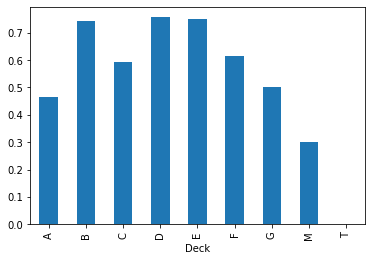

In [13]:
# Keep first letter of cabin (indicating deck) only and insert 'M' for missing

all_data['Deck'] = all_data['Cabin'].apply(lambda c: c[0] if pd.notnull(c) else 'M')
print('Survival rate by cabin')
all_data[['Deck', 'Survived']].groupby('Deck')['Survived'].mean().plot(kind='bar')

In [14]:
# Take a look at "missings"

display(all_data.isnull().sum())

Age               0
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Deck              0
dtype: int64

# Feature engineering

## Binning

<AxesSubplot:>

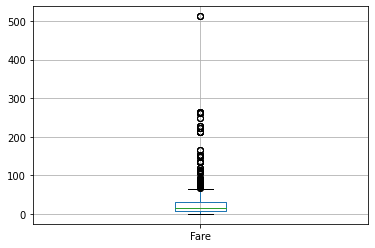

In [15]:
# Check outliers for continuous variables Fare and Age

all_data.boxplot(column=['Fare'])

<AxesSubplot:>

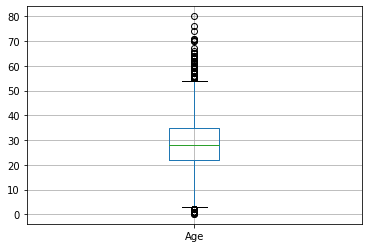

In [16]:
all_data.boxplot(column=['Age'])

In [17]:
# Outliers can disrupt learning, so split up the distribution for each

# For Fare, use qcut to assign approximately equal number of cases to each category

all_data['Fare'] = pd.qcut(all_data['Fare'], 5)
all_data['Fare'].value_counts()

(-0.001, 7.854]      275
(21.558, 41.579]     265
(41.579, 512.329]    259
(7.854, 10.5]        255
(10.5, 21.558]       255
Name: Fare, dtype: int64

In [18]:
# For Age, use cut to split according to values

all_data['Age'] = pd.cut(all_data['Age'].astype(int), 5)
all_data['Age'].value_counts()                                  

(16.0, 32.0]     779
(32.0, 48.0]     265
(-0.08, 16.0]    146
(48.0, 64.0]     106
(64.0, 80.0]      13
Name: Age, dtype: int64

## New feature creation

<AxesSubplot:>

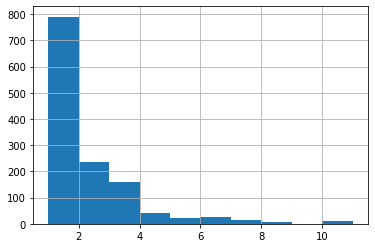

In [19]:
# Combine sibSp and Parch to create new feature Family_Size

all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['Family_Size'].hist()

<AxesSubplot:>

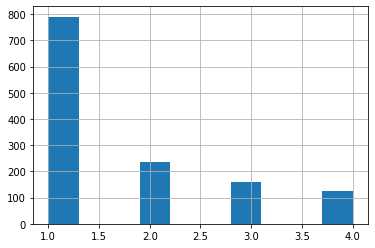

In [20]:
# Bin family size to group to group family size of four of higher into a single value

all_data['Family_Size_Bin'] = all_data['Family_Size'].map(lambda fs: fs if fs <= 3 else (4 if fs > 3 else 0))
all_data['Family_Size_Bin'].hist()

In [21]:
# Create Ticket_Frequency feature

all_data['Ticket_Freq'] = all_data.groupby('Ticket')['Ticket'].transform('count')

In [22]:
train_data, test_data = divide_titanic_df(all_data)
y = train_data["Survived"]

features = ["Pclass", "Sex", "Family_Size_Bin", "Age", "Fare", "Deck", "Ticket_Freq", "Embarked"]

all_dummies = pd.get_dummies(all_data[features])
X = all_dummies.loc[:890]
X_test = all_dummies.loc[891:]
display(X_test)

,Pclass,Family_Size_Bin,Ticket_Freq,Sex_female,Sex_male,"Age_(-0.08, 16.0]","Age_(16.0, 32.0]","Age_(32.0, 48.0]","Age_(48.0, 64.0]","Age_(64.0, 80.0]",...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T,Embarked_C,Embarked_Q,Embarked_S
891,3,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
892,3,2,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
893,2,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
894,3,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
895,3,3,2,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1305,1,1,3,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1306,3,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1307,3,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [23]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# Convert 'Survived' to int
output['Survived'] = output['Survived'].astype(int)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
